In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 6.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

Mounted at /content/drive


# 1. Download the data and briefly analyze the data frames in order to make the work plan

In [ ]:
contract = pd.read_csv("/datasets/final_provider/contract.csv")
internet = pd.read_csv("/datasets/final_provider/internet.csv")
personal = pd.read_csv("/datasets/final_provider/personal.csv")
phone = pd.read_csv("/datasets/final_provider/phone.csv")

## 1.1 `contract`

In [ ]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [ ]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Notes about the `contract`:

There are 7043 entries in this table. No explict missing values. The data types of some columns need be converted.

Insights on some meaningful columns:

* `customerID`: indicates there are 7043 customers in this project.
* `EndDate`: this is the label of this project. This column combines data types rather than a simple binary type. It will be addressed in the feature engineering part.
* `Type`: this is the contract type, I think this column is crucial. If the type is 'Month-to-month', the customer can leave anytime and hard to predict, but if the type is 'One year', there should few customers leave before the end of contract. I'll check this later.

## `internet`

In [ ]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [ ]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Notes about the `internet`:

There are 5517 entries in this table. No explict missing values. The data types of some columns need be converted.

Insights on some meaningful columns:
* `customerID`. The count number of this column is less than `contract` table. It shows about 1500 customers don't have internet service. It also tell us that if we merge these two table based on the `customerID`, there will be 1500 rows missing values.

### `personal`

In [ ]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [ ]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Notes about the `personal`:

There are 7043 entries in this table, the count number is same to `contract`, it shows every customer has his/her demographic information. No explict missing values. The data types of some columns need be converted.

Insights on some meaningful columns:
* `Partner` and `Dependents`: Check wether customers who have parter or dependent are less likely leave the service.

## `phone`

In [ ]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [ ]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Notes about the internet:

There are 6361 entries in this table, it shows about 650 customers don't have the calling service. No explict missing values. The categorical value of `MultipleLines` need be encoded.



## Brief analysis of these four tables

These four tables contains 7043 customers' demographic and services information. Some of customers don't use certain services, e.g. internet and multiple lines.

For individual dataframe, there is no explicit missing values, but if I merge these four table together based on the `customerID`, there will be about 2000 rows with missing values.

To complete this project, I need to merge these four tables together and then I'll continue to preprocess and make EDA on the merged data.

In [ ]:
merged1 = contract.merge(internet, on=['customerID'], how='left')
merged2 = merged1.merge(personal, on=['customerID'], how='left')
df = merged2.merge(phone, on=['customerID'], how='left')

In [ ]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   InternetService   5517 non-null   object 
 9   OnlineSecurity    5517 non-null   object 
 10  OnlineBackup      5517 non-null   object 
 11  DeviceProtection  5517 non-null   object 
 12  TechSupport       5517 non-null   object 
 13  StreamingTV       5517 non-null   object 
 14  StreamingMovies   5517 non-null   object 
 15  gender            7043 non-null   object 
 16  SeniorCitizen     7043 non-null   int64  


I've merged all dataframes to one table. I used the merge rule `how='left'`, because the table of `contract` contains the target `EndDate`. Even if other tables contain more `customerID` which are not in `contract`, we don't know their labels, it's useless for this project. I'll implement all data science process on it.

# 2. Proposed work Plan

According to the project criterion, the AUC-ROC, we know it's a classification project. The target of this project is to predict whether the customer will be chrun or not.

Based on the given information, I will design the working plan which will carry out the following steps:

1. preprocess data. In this step, I'll investigate all columns one by one and apply appropriate methods on them.
    * Replace all column names into the snake_case type
    * Convert to appropriate data types, e.g. datetime, float, int...
    * Fill missing values
    * Other preprocess approaches if necessary.
2. EDA.
    * Check data distribution and outliers.
    * Target balance
    * Check correlations between target and features
    * Analyze some categorical features, e.g. `Type` and `InternetService`
3. Feature Engineering
    * `EndDate`: The target column is not a simple binary type, but it contains churn date. If I convert it to 'Yes' or 'No', it will loss important information. I plan to save this information, such like make a new feature 'tenure' to represent the contract peroid.
    * Make a new feature to indicate if customer use extra internet services
    * One-hot encoding or label encoding based on the model adaptability.
    * Scaling the numeric data
    * Remove redundant features
    * Split the data to training, validation and test sets
4. Train models. In this part, I will choose some popular classifiers, e.g. Logistic Regression, Decision Tree, Random Forest, XGBoost, LightGBM, CatBoost.
5. Fine tune the models. I'll use the RandomSearchCV and optuna to find the best parameters for those models.
6. Test the model on the test set. I'll evaluate ROC-AUC metric on the testset.
7. Conclusion and the next step suggestion.

# 3. Preprocessing

Replace all column names into the snake_case type
Convert to appropriate data types, e.g. datetime, float, int...
Fill missing values
Other preprocess approaches if necessary.

## 3.1 Rename the column names

In [ ]:
df.rename(columns={"customerID": "customer_id", "BeginDate": "begin_date",  'EndDate': 'end_date', 'Type': 'type', 'PaperlessBilling':'paperless_billing', 'PaymentMethod':'payment_method',
                   'MonthlyCharges': 'monthly_charges', 'TotalCharges':'total_charges', 'InternetService':'internet_service', 'OnlineSecurity':'online_security', 'OnlineBackup':'online_backup',
                   'DeviceProtection':'device_protection', 'TechSupport': 'tech_support', 'StreamingTV': 'streaming_TV', 'StreamingMovies': 'streaming_movies', 'SeniorCitizen': 'senior_citizen',
                   'Partner': 'partner', 'Dependents': 'dependents', 'MultipleLines': 'multiple_lines'}, inplace=True)

In [ ]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_TV,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


## 3.2 Address the missing values

In [ ]:
df.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_TV         1526
streaming_movies     1526
gender                  0
senior_citizen          0
partner                 0
dependents              0
multiple_lines        682
dtype: int64

All missing values are from two tables, `internet` and `phone`, I'll compare the time distribution of missing data with the whole dataset.


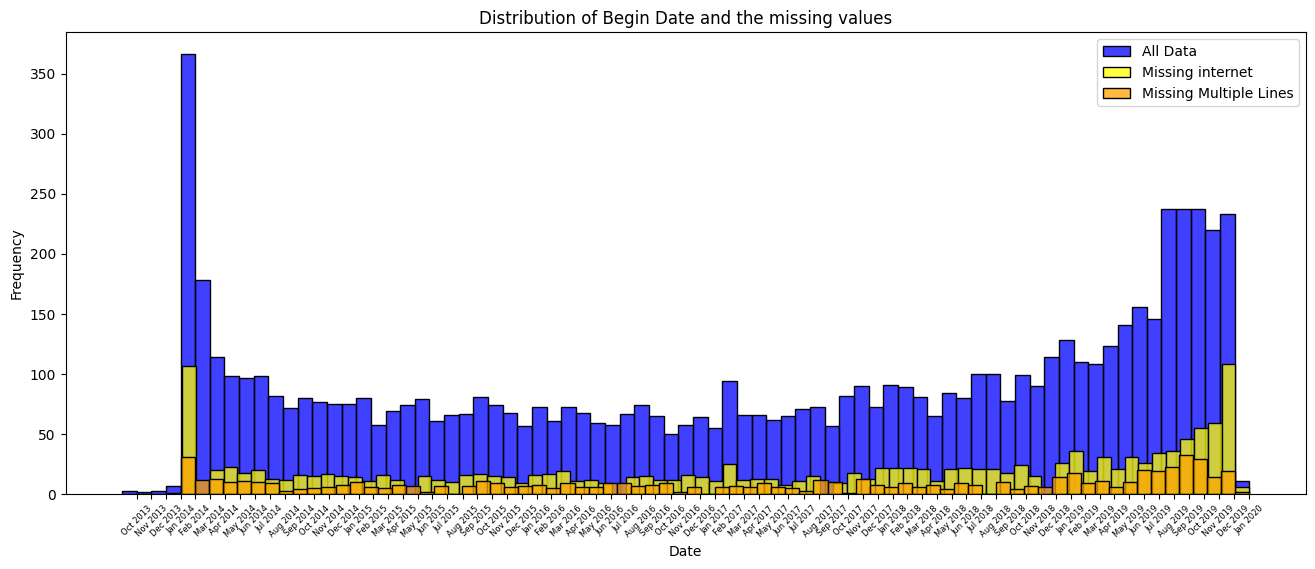

In [ ]:
df['begin_date'] = pd.to_datetime(df['begin_date'])
begin_date_range = pd.date_range(start=df['begin_date'].min(), end=df['begin_date'].max(), freq='M')
plt.figure(figsize=(16, 6))
sns.histplot(data=df, x='begin_date', bins=77,  color='blue', label='All Data')
sns.histplot(data=df[df['internet_service'].isna()], x='begin_date', bins=77, color='yellow', label='Missing internet')
sns.histplot(data=df[df['multiple_lines'].isna()], x='begin_date', bins=77, color='orange', label='Missing Multiple Lines')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Distribution of Begin Date and the missing values')
plt.xticks(begin_date_range, [date.strftime('%b %Y') for date in begin_date_range], rotation=45, fontsize=6)
plt.legend()
plt.show()

We can find that the frenquency distributions of missing data are same to the whole data. It means the missing values are not from a certain time slot.

Since the missing values are categorical, I'll replace them to 'Unknown'.

In [ ]:
df.fillna('Unknown', inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
 8   internet_service   7043 non-null   object        
 9   online_security    7043 non-null   object        
 10  online_backup      7043 non-null   object        
 11  device_protection  7043 non-null   object        
 12  tech_support       7043 non-null   object        
 13  streaming_TV       7043 non-null   object        
 14  streamin

### 3.3 Convert the data types

In [ ]:
df['total_charges'] = pd.to_numeric(df['total_charges'], downcast="float", errors='coerce')
df['senior_citizen']  = df['senior_citizen'].apply(lambda x: 'Yes' if x == 1 else 'No')

In [ ]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_TV,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.850000,DSL,No,Yes,No,No,No,No,Female,No,Yes,No,Unknown
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.500000,DSL,Yes,No,Yes,No,No,No,Male,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.150002,DSL,Yes,Yes,No,No,No,No,Male,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.750000,DSL,Yes,No,Yes,Yes,No,No,Male,No,No,No,Unknown
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.649994,Fiber optic,No,No,No,No,No,No,Female,No,No,No,No


# 4. EDA

## 4.1 The target, `end_date`

Before investigating the label column, I'll assigning a dummy value to 'No' in order to keep data consistent and easy to calculate the date difference later.

In [ ]:
df.loc[df['end_date'] == 'No', 'end_date'] = '2023-08-11 00:00:00'
df['end_date'] = pd.to_datetime(df['end_date'])

### 4.1.1 Distribution

I've already made a distribution of `begin_date`, now I'll add the `end_date`.

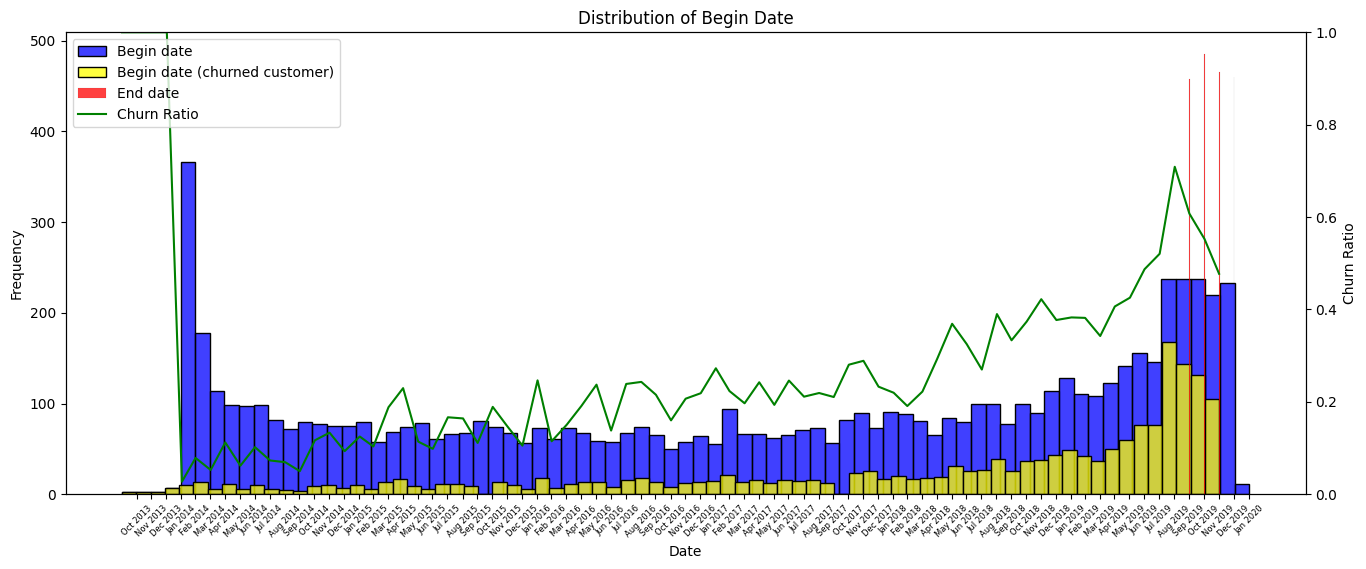

In [ ]:
begin_date_range = pd.date_range(start=df['begin_date'].min(), end=df['begin_date'].max(), freq='M')
# ax1: Histogram of 'begin_date' and 'end_date'
fig, ax1 = plt.subplots(figsize=(16, 6))
sns.histplot(data=df, x='begin_date', bins=77,  color='blue', label='Begin date')
sns.histplot(data=df[~(df['end_date'] == '2023-08-11')], x='begin_date', color='yellow', bins=77, label='Begin date (churned customer)')
sns.histplot(data=df[~(df['end_date'] == '2023-08-11')], x='end_date', color='red', bins=77, label='End date')
ax1.set_xlabel('Date')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Begin Date')

# ax2: Ratio of churned customers
ax2 = ax1.twinx()
churn_ratio = df[~(df['end_date'] == '2023-08-11')]['begin_date'].dt.to_period('M').value_counts() / df['begin_date'].dt.to_period('M').value_counts()
#churn_ratio.fillna(0, inplace=True)
ax2.plot(churn_ratio.index.to_timestamp(), churn_ratio.values, color='green', label='Churn Ratio')

ax2.set_ylabel('Churn Ratio')
ax2.set_ylim(0, 1)

# combine legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

ax1.set_xticks(begin_date_range)
ax1.set_xticklabels([date.strftime('%b %Y') for date in begin_date_range], rotation=45, fontsize=6)

#plt.tight_layout()
plt.show()

Conclusion of this distribution plot:

* Begin_date (blue): The data range is from 2013-10 to 2020-02. The distribution is kind of uniform with two peaks. I divide the count numbers of begin date into 3 levels. The first level are two peaks which are 2014-02 with 366 samples and five months from 2019-09 to 2022-01 with around 230 samples monthly. The second level is from 2014-03 to 2019-08 with count number from 65 to 178. The third level is 2013-10 to 2014-01 and 2020-02 with very few number less than 11.

* Begin date of churned customers (yellow), ratio of churned customers (green line): The yellow histogram indicates the begin date of churned customers, For churned customers, they are from every month. The green line shows the ratio of churned customers. As the time goes by, the trend of ratio is incresed from 0.1 (2014) to 0.7 (2020-09).

* End date (red lines): All churned customers leave in 4 months from 2019-10 to 2020-01.

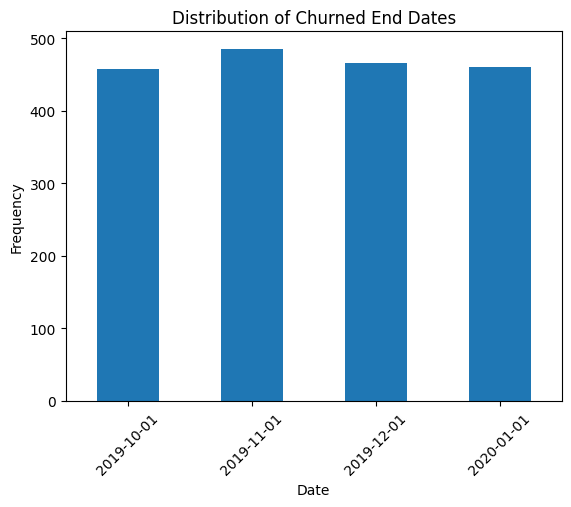

In [ ]:
churned = df[~(df['end_date'] == '2023-08-11')]
end_date_counts = churned['end_date'].value_counts().sort_index()
end_date_counts.plot(kind='bar')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Distribution of Churned End Dates')
plt.xticks(rotation=45, ticks=range(len(end_date_counts)), labels=end_date_counts.index.strftime('%Y-%m-%d'))
plt.show()

### 4.1.2 Target balance

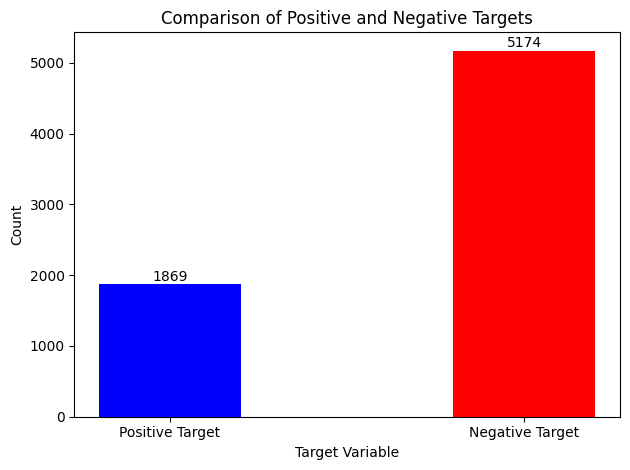

In [ ]:
num_positive_target = len(df[~(df['end_date'] == '2023-08-11')])
num_negative_target = len(df[(df['end_date'] == '2023-08-11')])
target_values = [num_positive_target, num_negative_target]
plt.bar(['Positive Target', 'Negative Target'], target_values, color=['blue', 'red'], width=0.4)
plt.xlabel('Target Variable')
plt.ylabel('Count')
plt.title('Comparison of Positive and Negative Targets')
for i, v in enumerate(target_values):
    plt.text(i, v+10, str(v), ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [ ]:
print(f"The count number of churned customer is {num_positive_target}, the ratio of churn is {len(df[~(df['end_date'] == '2023-08-11')]) / len(df):.3f}")

The count number of churned customer is 1869, the ratio of churn is 0.265


The positive target takes 26.5% of whole sample space, I'll apply appropriate method to make it evener.

### 4.1.3 Extract time information from the target column

There is a special place in this project apart from other projects is the target label is mix-type rather than purely binary value. I could convert this column to binary simplely, but it will lose the time information such like how many months a churned customer stay in the contract. Therefore I will calculate the difference between `end_date` and `begin_date` and make a new feature to save it.

One thing need to be noticed, this `usage_months` column will cause data leak. Since if the model find the relationship between `begin_date` and `usage_months`, it will predict if the customer has already left or not. Therefore this column can only be used for analyzing rather than training.

For customers who still stay in the contract, I cannot use the current time to calculate. Since the minimum value, Aug, 2023 - Feb, 2020 = 30 months, which is less than the time span, 77 months. So the negative target will be coverd by the month differences. I need to make a dummy value to represent the negative labels. This dummy value should neighter too small (be coverd by the real month differences) nor too large (will impact the scaling). Because the time span is 77 months, so I'll set this value to 200, which is 2 ~ 3 times than maximum time span.

In [ ]:
df['usage_months'] = (df['end_date'].dt.year - df['begin_date'].dt.year) * 12 + (df['end_date'].dt.month - df['begin_date'].dt.month)
df.loc[df['end_date'] == '2023-08-11', 'usage_months'] = 200

### 4.1.4 `usage_months` distribution

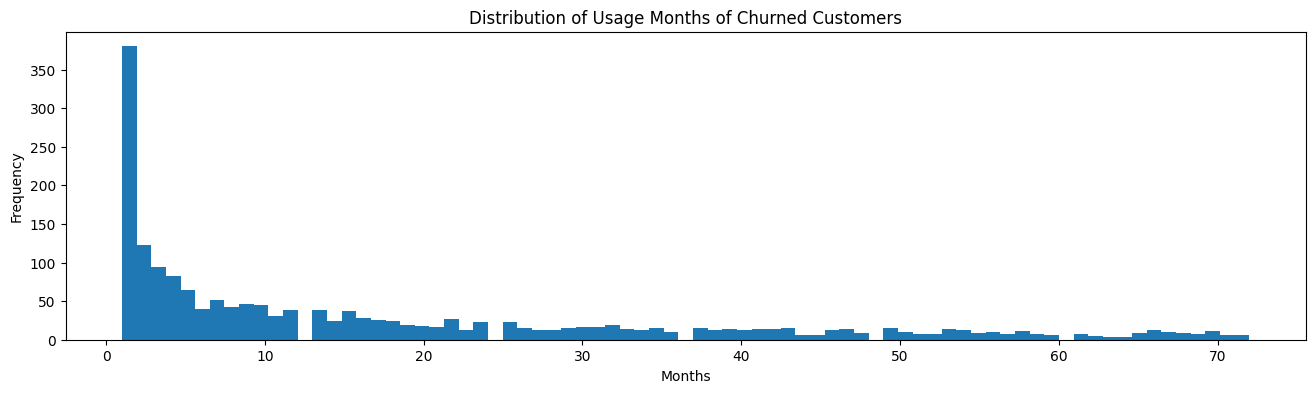

In [ ]:
df[~(df['end_date'] == '2023-08-11')]['usage_months'].plot(kind='hist', bins=77, figsize=(16, 4))
plt.xlabel('Months')
plt.ylabel('Frequency')
plt.title('Distribution of Usage Months of Churned Customers')
plt.show()

In [ ]:
print(f"There are {len(df[df['usage_months'] <= 5])} churned customers whose usage months is less 6 months. It takes {len(df[df['usage_months'] <= 5]) / 1869:.3f} of all churned customers.")

There are 744 churned customers whose usage months is less 6 months. It takes 0.398 of all churned customers.


### 4.1.5 Make a new target column

I've already extracted time information from the original target column, so I can make a new binary target column `churn`.

In [ ]:
df['churn'] = df['end_date'].apply(lambda x: 0 if x == pd.to_datetime('2023-08-11') else 1)

In [ ]:
df['churn'].value_counts()

0    5174
1    1869
Name: churn, dtype: int64

The target column is imbalanced. I'll deal with it later.

## 4.2 Analysis based on target column




In [ ]:
churned_df = df[df['churn'] == 1]
stay_df = df[df['churn'] == 0]

### 4.2.1 `monthly_charge` and `total_charges`







There are only two numeric columns, `monthly_charge` and `total_charges`. The `total_charges` is the integer multiplies of `monthly_charge`.

I'll analyze the distribution of these two columns based on the target column

In [ ]:
ori_monthly = df['monthly_charges']
ori_total = df['total_charges']
churned_monthly = churned_df['monthly_charges']
churned_total = churned_df['total_charges']
stay_monthly = stay_df['monthly_charges']
stay_total = stay_df['total_charges']

charges_df = pd.DataFrame({'ori_monthly': ori_monthly,'churned_monthly': churned_monthly,'stay_monthly':stay_monthly,'ori_total': ori_total, 'churned_total': churned_total, 'stay_total':stay_total})
charges_df.describe()

,ori_monthly,churned_monthly,stay_monthly,ori_total,churned_total,stay_total
count,7043.000000,1869.000000,5174.000000,7032.000000,1869.000000,5163.000000
mean,64.761692,74.441332,61.265124,2283.300537,1531.796021,2555.344238
std,30.090047,24.666053,31.092648,2266.771484,1890.822998,2329.457031
min,18.250000,18.850000,18.250000,18.799999,18.850000,18.799999
25%,35.500000,56.150000,25.100000,401.450012,134.500000,577.825012
50%,70.350000,79.650000,64.425000,1397.475098,703.549988,1683.599976
75%,89.850000,94.200000,88.400000,3794.737549,2331.300049,4264.125000
max,118.750000,118.350000,118.750000,8684.799805,8684.799805,8672.450195


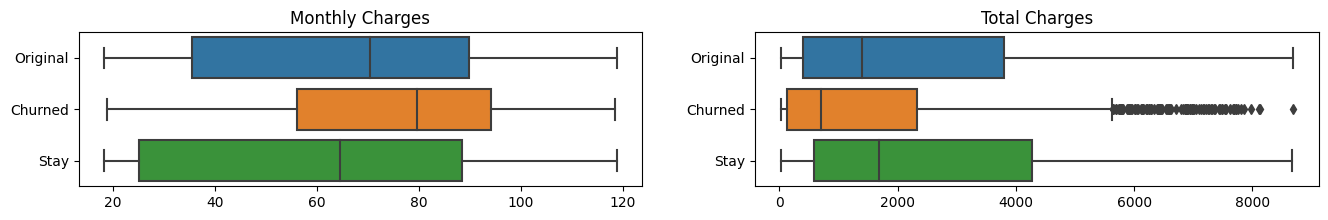

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 2))

sns.boxplot(ax=axes[0], data=[df['monthly_charges'], churned_df['monthly_charges'], stay_df['monthly_charges']], orient='h')
axes[0].set_title('Monthly Charges')
axes[0].set_yticklabels(['Original', 'Churned', 'Stay'])

sns.boxplot(ax=axes[1], data=[df['total_charges'], churned_df['total_charges'], stay_df['total_charges']], orient='h')
axes[1].set_title('Total Charges')
axes[1].set_yticklabels(['Original', 'Churned', 'Stay'])

plt.show()

#### `monthly_charges`
The range of `monthly_charge` in three dataframes are very close, from 18.25 to 118.75. What makes me suprised is the interquatile range (IQR) from `churned_df`, which is from 56.15 to 94.2 and higher than `stay_df`. The median of `churned_df` is 79.65 while the median of `stay_df` is only 64.42.

#### `total_charges`
Similar to `monthly_charges`, both maximum and minimum values from three dataframes are very close, from 18.85 to 8684.80. This time the IQR from `churned_df` is less than `stay_df`, the reason might be the usage months of churned customers are less than customers who still stay in the service.

### 4.2.2 Analysis of Categorical Features

I'll create a subplot to analyze each categorical feature in the original dataframe, the churned dataframe and the stay dataframe.

In [ ]:
def create_stacked_bar(column, ax=None):
    dfs = [df, churned_df, stay_df]
    dfs_names = ['origin_df', 'churned_df', 'stay_df']
    types = df[column].value_counts().index.tolist()
    # create bar_df to store data used by plot
    bar_df = pd.DataFrame(index=dfs_names, columns=types)
    for idx, df_object in enumerate(dfs):
        value = df_object[column].value_counts(normalize=True).reindex(types).round(3)
        bar_df.loc[dfs_names[idx]] = value
    # single stacked bar plot
    if ax is None:
        fig, ax = plt.subplots()
    bottom = np.zeros(3)
    for k, v in bar_df.items():
        ratio = v.to_list()
        p = ax.bar(dfs_names, ratio, width=0.4, label=k, bottom=bottom)
        bottom += ratio
        ax.bar_label(p, label_type='center')

    ax.set_title(column)
    ax.set_ylabel('Percentage')
    ax.legend(loc='lower left')
    ax.set_xticks(dfs_names)
    ax.set_xticklabels(dfs_names, rotation=0)
    if ax is None:
        plt.tight_layout()
        plt.show()

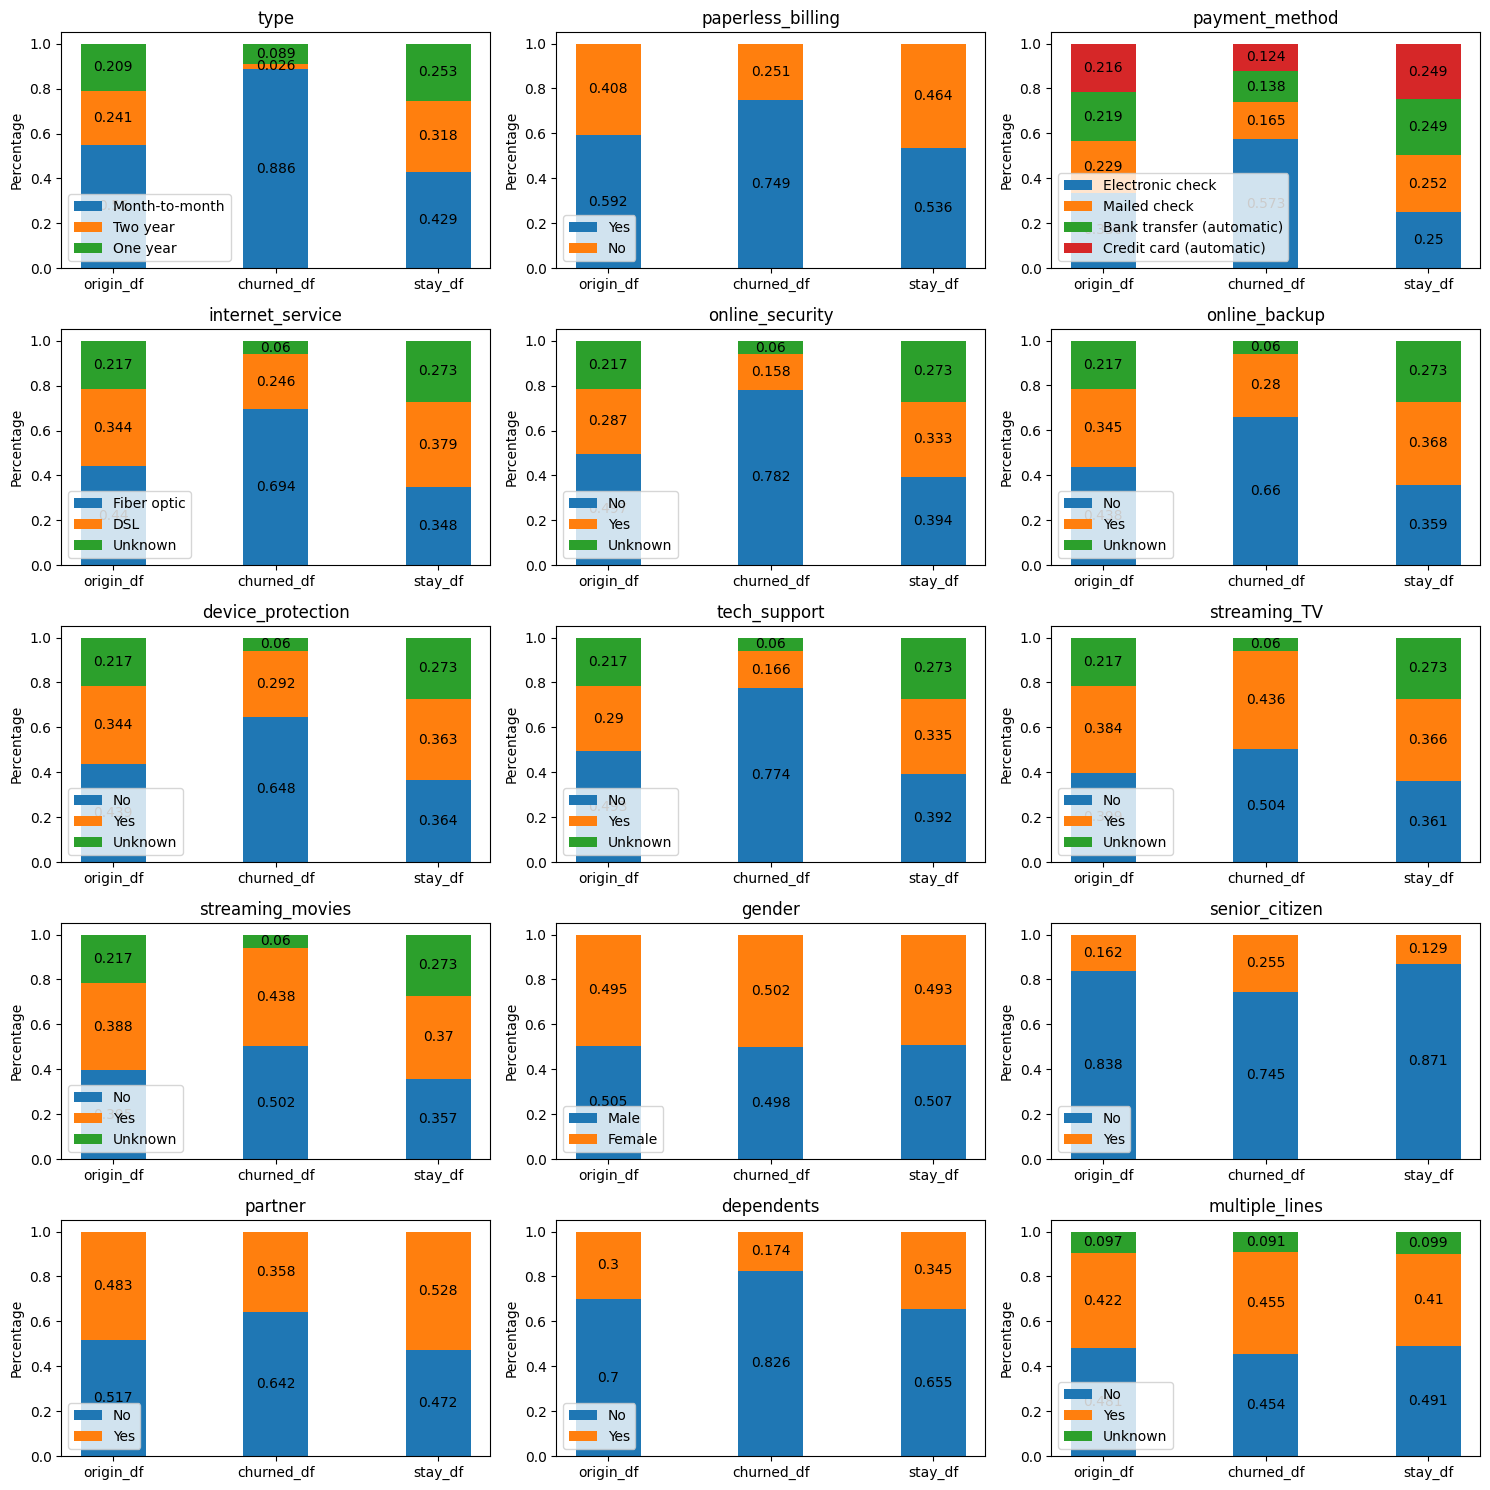

In [ ]:
categorical_list = ['type', 'paperless_billing', 'payment_method', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_TV', 'streaming_movies', 'gender', 'senior_citizen',
                     'partner', 'dependents', 'multiple_lines']
num_rows = 5
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
axes = axes.flatten()

for i, column in enumerate(categorical_list):
    ax = axes[i]
    create_stacked_bar(column, ax)

plt.tight_layout()
plt.show()

Let me introduce some interesting features:

* `type`: There are 3 types of contract, 'month-to-month', 'one year' and 'two years'. Generally, customers are less likely to quit the contracts before the contracts are not end. On the other hand, there isn't constriant for customers with 'month-to-month', they could leave at any time. In `stay_df`, 'two years' type takes 25.3%, 'one year' takes 31.8%, and 'month-to-month' takes only 42.9%. But in 'churned_df', the sum of 'two years' and 'one year' is only 11.4%, 88.6% churned customers are 'month-to-month'.
* `paperless_billing`: In `stay_df`, the cutomers who use paperless billing are a little bit more than whom don't use. But in `churned_df`, the number of users using paperless billing is three times different.
* `payment_method`: There are 4 types of payment method. In `stay_df`, these 4 types split shares into equal parts. For Bank Transfer and Credit Card, these two automatic payment methods take 50%. But in `churned_df`, the automatic payment methods only takes 25%.
* Internet and extra services: There are many missing values in this table, I've fill them with 'Unkown'. Most of them are from the `stay_df`, it takes 27.3%. But we can still get insight except the missing values.
    * `internet_service`: In `stay_df`, the number of customers who use Fiber optic is close to customers use DSL. But in `churned_df`, the number of customers who use Fiber optic take 68.4% while 24.6% customers use DSL.
    * `online_security`, `online_backup`, `device_protection` and `tech_support`: These 4 features display similar distribution, so I summarize them together. In `stay_df`, the number of customers who use these services are very clost to whom don't use. While in `churned_df`, the number of customers who don't use these extra service are 2 ~ 3 times more than customers use them.
    * `streaming TV` and `streaming_movie`: Both in `churned_df` and `stay_df`, the number of customers who use the services are close to don't use.
* `parter` and `dependents`. In these two features, the proportion of churned users without a partner or dependents is higher than the proportion of users who remain in the service.
* `senior_citizen`: The proportion of elder customers who still stay in the service is the half of churned customers.

## $.3 Correlation

### 4.3.1 Correlation between numeric features

In [ ]:
numeric_features = ['monthly_charges', 'total_charges', 'usage_months']

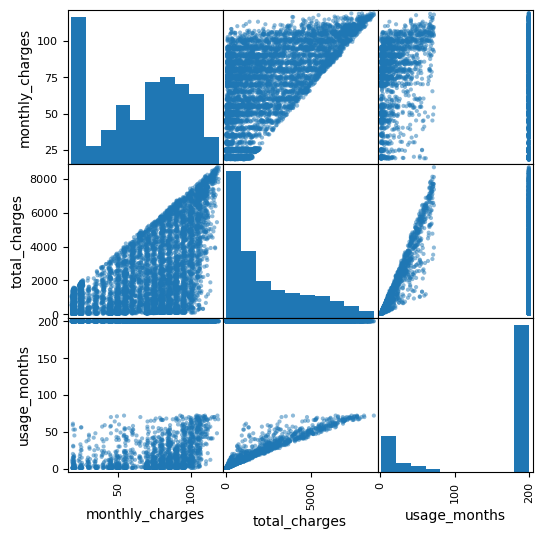

In [ ]:
pd.plotting.scatter_matrix(df[numeric_features], figsize=(6, 6))
plt.show()

In [ ]:
corr_charges = df['total_charges'].corr(df['monthly_charges'])
corr_months = df['total_charges'].corr(df['usage_months'])
print(f"The correlation between 'total_charges' and 'monthly_charges' is {corr_charges:.2f}, and the correlation between 'total_charges' and 'usage_months' is {corr_months:.2f}")

The correlation between 'total_charges' and 'monthly_charges' is 0.65, and the correlation between 'total_charges' and 'usage_months' is 0.25


We can see that there are positive linear correlationship between the feature of `total_charges` and other two features, although the correlation coefficient is not as high as the other. Because I've set an extreme value 200 to the column of `usage_months`.

That makes sense, because the `total_charges` is the integer multiplies of `monthly_charges`, and the `usage_months` should be the quotient of `total_charges` divided by `monthly_charges`. Therefore I'll remove the `total_charges` before training.

### Correlation between categorical features

In [ ]:
def create_corr_heatmap_subplot(ax, df, title):
    binary_df = df[binary_list]
    # remove rows including 'unknown'
    binary_df = binary_df[~binary_df.isin(['Unknown']).any(axis=1)]
    binary_df = binary_df.replace({'Yes': 1, 'No': 0})
    correlation_matrix = binary_df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax,
                annot_kws={"size": 8}, fmt=".2f")
    ax.set_title(title)

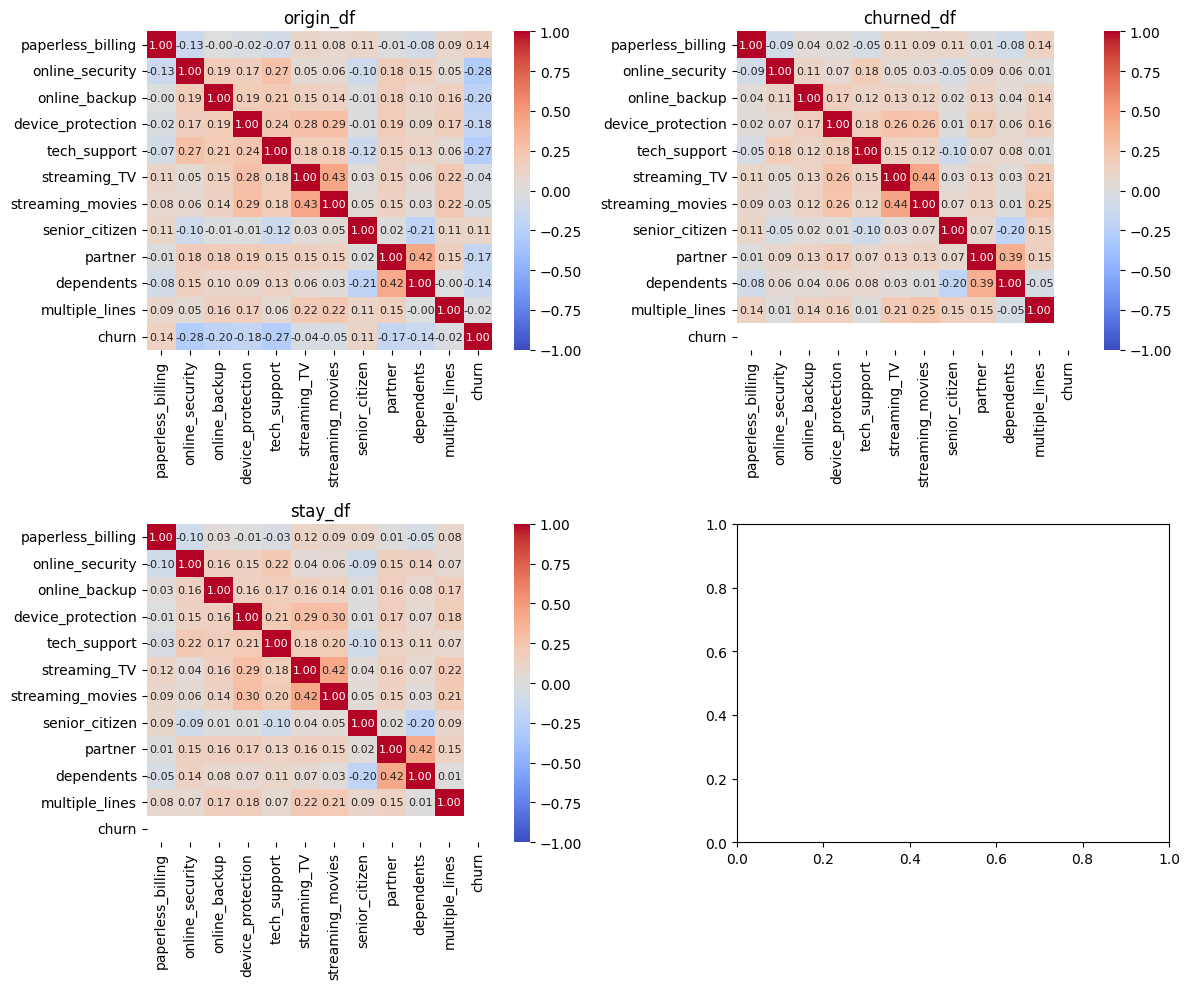

In [ ]:
binary_list = ['paperless_billing', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_TV', 'streaming_movies', 'senior_citizen','partner', 'dependents', 'multiple_lines', 'churn']
dfs = [df, churned_df, stay_df]
dfs_names = ['origin_df', 'churned_df', 'stay_df']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, (data, name) in enumerate(zip(dfs, dfs_names)):
    create_corr_heatmap_subplot(axes[idx], data, name)

plt.tight_layout()
plt.show()

According to the correlation heatmaps, there are not very strong linear correlation among fetures and the target except two pairs, i.e. `streaming TV` vs `streaming Movie` and `partner` vs `dependents`. There is not significant difference between three dataframes.

* `streaming TV` vs `streaming Movie`: Customers who order `streaming TV` are more likely order `streaming Movie`, but the correlation is below 0.5. I won't remove one of them before training.

* `partner` vs `dependents`: Both partner and dependents stand for the family members, the correlation is below 0.5 too, so I won't remove one of them.

* Although there is positive linear correlation among the features of internet and extra services, the correlation is not strong enough to choose one feature to represent others.

* As the previous discussion in 4.2.2, customers who order the internet services and with family members are not likely to quit the contract. It is verified in this heatmap, the features of `churn` has negative correlation with internet services and family members.

Note: There are no correlations between `churn` and other features in the heatmap of `churn_df` and `stay_df`, since they don't have the `churn` column.



# 5. Feature Engineering

Feature Engineering
    * `EndDate`: The target column is not a simple binary type, but it contains churn date. If I convert it to 'Yes' or 'No', it will loss important information. I plan to save this information, such like make a new feature 'tenure' to represent the contract peroid.
    * Make a new feature to indicate if customer use extra internet services
    * One-hot encoding or label encoding based on the model adaptability.
    * Scaling the numeric data
    * Remove redundant features
    * Split the data to training, validation and test sets

## 5.1 Feature selection

In [ ]:
drop_list = ['customer_id', 'end_date', 'total_charges', 'usage_months']
df.drop(drop_list, axis=1, inplace=True)

* `end_date`: This is the original target, I've extracted the time information and mapped the positive and negative labels in order to generate a new target column `churn`. So I dropped it.
* `usage_months`: I realize this column will cause data leak. Since if the model find the relationship between `begin_date` and `usage_months`, it will predict if the customer has already left or not. Therefore this column can only be used for analyzing rather than training.
* `total_charges`: Similar to `usage_months`, it will cause data leak if model finds this column is how many times the 'month_charges' value.

## 5.2 Convert the datatime to number

In [ ]:
# Convert the datetime to float, otherwise it'll be error during training with some models
df["begin_date"] = df["begin_date"].dt.strftime('%Y%m').astype('int64') # only keep year and month
df['begin_date'] = df['begin_date'] - 200000

## 5.3 Encoding the categorical features

### 5.3.1 One-Hot Encoding

In [ ]:
categorical_list = ['type', 'paperless_billing', 'payment_method', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_TV', 'streaming_movies', 'gender', 'senior_citizen',
                     'partner', 'dependents', 'multiple_lines']
ohe_encoded_df = pd.get_dummies(df, columns=categorical_list, drop_first=True)
ohe_encoded_df.reset_index(drop=True, inplace=True)

### 5.3.2 Label Encoding

In [ ]:
label_encoder = OrdinalEncoder()
label_encoded_df = label_encoder.fit_transform(df[categorical_list])
reset_index_df = df.reset_index(drop=True).copy()
label_encoded_df = pd.concat([reset_index_df.drop(columns=categorical_list), pd.DataFrame(label_encoded_df, columns=categorical_list)], axis=1)
label_encoded_df.head()

,begin_date,monthly_charges,churn,type,paperless_billing,payment_method,internet_service,online_security,online_backup,device_protection,tech_support,streaming_TV,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
0,2001,29.85,0,0.0,1.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1704,56.95,0,1.0,0.0,3.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1910,53.85,1,0.0,1.0,3.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1605,42.30,0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1909,70.70,1,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 5.4 Upsampling imbalanced dataset

I've printed that the negative label is about 3 times more than the positive labels. So I'll upsample 3 times of the positive class.

In [ ]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    #print(features_zeros.shape, features_ones.shape, target_zeros.shape,target_ones.shape)

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=42
    )

    return features_upsampled, target_upsampled

## 5.5 Split and scaling datasets


In [ ]:
def split_scaling_datasets(df):
    X = df.drop('churn', axis=1)
    y = df['churn']

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # upsample
    X_train, y_train = upsample(X_train, y_train, 3)

    # scaling
    scaled_X_train = X_train.copy()
    scaled_X_val = X_val.copy()
    scaler = StandardScaler()
    scaler.fit(X_train)
    scaled_X_train.loc[:, :] = scaler.transform(scaled_X_train.loc[:, :])
    scaled_X_val.loc[:, :] = scaler.transform(scaled_X_val.loc[:, :])


    return scaled_X_train, X_train, scaled_X_val, X_val, X_test, y_train, y_val, y_test

Store the un-scaled X for testing session

In [ ]:
ohe_X_train, unscaled_ohe_X_train, ohe_X_val, unscaled_ohe_X_val, ohe_X_test, ohe_y_train, ohe_y_val, ohe_y_test = split_scaling_datasets(ohe_encoded_df)
label_X_train, unscaled_label_X_train, label_X_val, unscaled_label_X_val, label_X_test, label_y_train, label_y_val, label_y_test = split_scaling_datasets(label_encoded_df)

Now we are ready to train models.

# 6. Train and validation

## 6.1 Train and validation with default settings

I'll create a `train_pipeline` function that can be re-used by different models.

In [ ]:
def train_pipeline(model_name, model, X_train, X_val, y_train, y_val):
    start = time.time()
    if model_name == 'CatBoost':
        model.fit(X_train, y_train, verbose=250)
    else:
        model.fit(X_train, y_train, )
    # y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    time_consume = round((time.time() - start), 3)
    return roc_auc, time_consume

In [ ]:
log_reg = LogisticRegression(random_state=42)
dtc_default = DecisionTreeClassifier(random_state=42)
rfc_default = RandomForestClassifier(random_state=42)
xgb_default = XGBClassifier(use_label_encoder=False, random_state=42)
lgb_default = LGBMClassifier(random_state=42)
cat_default = CatBoostClassifier(random_state=42)

model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM', 'CatBoost']
model_list = [log_reg, dtc_default, rfc_default, xgb_default, lgb_default, cat_default]

time_consume_list = []
auc_list = []

for idx, model_obj in enumerate(model_list):
    model_name = model_names[idx]
    if model_name == 'Logistic Regression' or model_name == 'XGBoost':
        roc_auc, time_consume = train_pipeline(model_name, model_obj, ohe_X_train, ohe_X_val, ohe_y_train, ohe_y_val)
    else:
        roc_auc, time_consume = train_pipeline(model_name, model_obj, label_X_train, label_X_val, label_y_train, label_y_val)
    auc_list.append(roc_auc)
    time_consume_list.append(time_consume)

result_df = pd.DataFrame({'Model': model_names, 'ROC-AUC': auc_list, 'Time Consume (S)': time_consume_list})
result_df

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[LightGBM] [Info] Number of positive: 3885, number of negative: 3635
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 389
[LightGBM] [Info] Number of data points in the train set: 7520, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.516622 -> initscore=0.066514
[LightGBM] [Info] Start training from score 0.066514
Learning rate set to 0.024383
0:	learn: 0.6819485	total: 51.7ms	remaining: 51.7s
250:	learn: 0.4026369	total: 780ms	remaining: 2.33s
500:	learn: 0.3546726	total: 1.52s	remaining: 1.52s
750:	learn: 0.3189338	total: 2.27s	remaining: 755ms
999:	learn: 0.2905205	total: 3.01s	remaining: 0us


,Model,ROC-AUC,Time Consume (S)
0,Logistic Regression,0.844991,0.292
1,Decision Tree,0.660220,0.140
2,Random Forest,0.848590,3.848
3,XGBoost,0.842517,1.112
4,LightGBM,0.848583,0.226
5,CatBoost,0.851875,3.176


According to the result table above, the ROC-AUC scores from different models with their default settings are listed.

The best three models are 'LightGBM', 'CatBoost' and 'Random Forest', those three models obtained 0.85 on the validation set.

I also list the `time consume` of training. The top 3 fastest models are 'Decision Tree', 'Logistic Regression' and 'LightGBM' which are less than 0.5 second.

## 6.2 Fine Tuning for finding the best parameters

Then I'll apply the `RandomizedSearchCV` to find the best hyperparameters of each model.

In [ ]:
def random_optimize(model_name, estimator, param_grid, X_train, y_train, n_iter, cv):
    print(f"Start searching params of {model_name}.")
    start = time.time()
    random_search = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=param_grid,
    n_iter=n_iter,
    scoring='roc_auc',
    cv=cv,
    verbose=1,
    n_jobs=-1
    )
    if model_name == 'CatBoost':
       random_search.fit(X_train, y_train, verbose=250)
    else:
        random_search.fit(X_train, y_train)
    print("Best parameters: ", random_search.best_params_)
    print("Best score: ", random_search.best_score_)
    print(f"The time consume of {model_name} parameter searching is {round((time.time() - start), 3)} seconds.")
    print("---------------------------------------------------------------")
    return random_search.best_params_

In [ ]:
param_grid_lgr = {'C': [0.03, 0.1, 0.3, 1],'penalty': ['l2'],'solver': ['newton-cg', 'sag'], 'max_iter': [5000, 10000,20000], 'tol': [3e-4, 1e-4, 3e-5], 'multi_class': ['ovr', 'multinomial'], 'warm_start': [True, False]}
param_grid_dtc = {'max_depth': [6, 9, 12], 'min_samples_split': [2, 4, 5, 8, 10], 'min_samples_leaf': [1, 2, 5], 'criterion': ['gini', 'entropy'],'splitter': ['best', 'random']}
param_grid_rfr = {'n_estimators': [50, 100, 200],'max_depth': [None, 5, 10],'min_samples_split': [4, 8, 16],'min_samples_leaf': [1, 2, 4, 8]}
param_grid_xgb = {'n_estimators': [200, 300, 400],'learning_rate': [0.05, 0.1, 0.3],'max_depth': [6, 9, 12], 'subsample': [0.9, 1.0, 1,1], 'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0.0, 0.01, 0.05], 'reg_lambda': [0.0, 0.01, 0.05]}
param_grid_lgb= {'learning_rate': [0.01,0.03, 0.05,0.1, 0.3], 'n_estimators': [100,300, 500,700, 1000], 'subsample': [0.8, 0.9, 1.0], 'colsample_bytree': [0.8, 0.9, 1.0],'reg_alpha': [0, 0.003, 0.01], 'reg_lambda': [0, 0.003, 0.01]}
param_grid_cat = {'learning_rate': [0.01, 0.1, 0.2, 0.4], 'n_estimators': [100, 1000, 5000, 10000], 'depth': [3, 6, 9, 12], 'l2_leaf_reg': [1e-4, 3e-4, 1e-3, 3e-3], 'min_child_samples': [50, 100, 150], 'subsample': [0.8, 0.9, 1.0]}

params_list = [param_grid_lgr, param_grid_dtc, param_grid_rfr, param_grid_xgb, param_grid_lgb, param_grid_cat]
best_params_list = []
for idx, param_grid in enumerate(params_list):
    model_name = model_names[idx]
    if model_name == 'Logistic Regression' or model_name == 'XGBoost':
        best_params = random_optimize(model_names[idx], model_list[idx], param_grid, ohe_X_train, ohe_y_train, n_iter=10, cv=5)
    elif model_name == 'CatBoost':
        best_params = {'subsample': 0.8, 'n_estimators': 5000, 'min_child_samples': 150, 'learning_rate': 0.01, 'l2_leaf_reg': 0.003, 'depth': 12}
    else:
        best_params = random_optimize(model_names[idx], model_list[idx], param_grid, label_X_train, label_y_train, n_iter=10, cv=5)
    best_params_list.append(best_params)
len(best_params_list)

Start searching params of Logistic Regression.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters:  {'warm_start': True, 'tol': 0.0001, 'solver': 'newton-cg', 'penalty': 'l2', 'multi_class': 'ovr', 'max_iter': 10000, 'C': 0.1}
Best score:  0.8283120809943367
The time consume of Logistic Regression parameter searching is 8.886 seconds.
---------------------------------------------------------------
Start searching params of Decision Tree.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters:  {'splitter': 'best', 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_depth': 12, 'criterion': 'entropy'}
Best score:  0.8641064723595673
The time consume of Decision Tree parameter searching is 1.63 seconds.
---------------------------------------------------------------
Start searching params of Random Forest.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters:  {'n_estimators': 200, 'min_samples_split': 8, 'min_sample

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Best parameters:  {'subsample': 0.9, 'reg_lambda': 0.0, 'reg_alpha': 0.01, 'n_estimators': 400, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best score:  0.9625985388021151
The time consume of XGBoost parameter searching is 203.122 seconds.
---------------------------------------------------------------
Start searching params of LightGBM.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Number of positive: 3885, number of negative: 3635
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 389
[LightGBM] [Info] Number of data points in the train set: 7520, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.516622 -> initscore=0.066514
[LightGBM] [Info] Start training from score 0.066514
Best parameters:  {'subs

6

Now the best hyperparameters of these 6 models are stored in `best_params_list`.

## 6.3 Train and validate again with best hyperparameters

In [ ]:
log_reg_opt = LogisticRegression(random_state=42, **best_params_list[0])
dtc_opt = DecisionTreeClassifier(random_state=42, **best_params_list[1])
rfc_opt = RandomForestClassifier(random_state=42, **best_params_list[2])
xgb_opt = XGBClassifier(use_label_encoder=False, random_state=42, **best_params_list[3])
lgb_opt = LGBMClassifier(random_state=42, **best_params_list[4])
cat_opt = CatBoostClassifier(random_state=42, **best_params_list[5])
opt_model_list = [log_reg_opt, dtc_opt, rfc_opt, xgb_opt, lgb_opt, cat_opt]

time_consume_list = []
auc_list = []

for idx, model_obj in enumerate(opt_model_list):
    model_name = model_names[idx]
    if model_name == 'Logistic Regression' or model_name == 'XGBoost':
        roc_auc, time_consume = train_pipeline(model_name, model_obj, ohe_X_train, ohe_X_val, ohe_y_train, ohe_y_val)
    else:
        roc_auc, time_consume = train_pipeline(model_name, model_obj, label_X_train, label_X_val, label_y_train, label_y_val)
    auc_list.append(roc_auc)
    time_consume_list.append(time_consume)

result_df['optimized ROC-AUC'] = auc_list
result_df['ROC-AUC difference'] = result_df['optimized ROC-AUC'] - result_df['ROC-AUC']
result_df

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[LightGBM] [Info] Number of positive: 3885, number of negative: 3635
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 389
[LightGBM] [Info] Number of data points in the train set: 7520, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.516622 -> initscore=0.066514
[LightGBM] [Info] Start training from score 0.066514
0:	learn: 0.6787839	total: 46.2ms	remaining: 3m 50s
250:	learn: 0.1366499	total: 5.36s	remaining: 1m 41s
500:	learn: 0.0796302	total: 12.2s	remaining: 1m 49s
750:	learn: 0.0516157	total: 17.6s	remaining: 1m 39s
1000:	learn: 0.0308859	total: 26.1s	remaining: 1m 44s
1250:	learn: 0.0179052	total: 32.9s	remaining: 1m 38s
1500:	learn: 0.0105537	total: 41.5s	remaining: 1m 36s
1750:	learn: 0.0066305	total: 48.6s	remaining: 1m 30s
2000:	learn: 0.004

,Model,ROC-AUC,Time Consume (S),optimized ROC-AUC,ROC-AUC difference
0,Logistic Regression,0.844991,0.292,0.844991,-1.110223e-16
1,Decision Tree,0.660220,0.140,0.776641,1.164210e-01
2,Random Forest,0.848590,3.848,0.863541,1.495025e-02
3,XGBoost,0.842517,1.112,0.825456,-1.706090e-02
4,LightGBM,0.848583,0.226,0.812871,-3.571230e-02
5,CatBoost,0.851875,3.176,0.835286,-1.658930e-02


After fine tuning, we got a list of optimized ROC-AUC scores. Comparing it with the previous scores, optimized scores of 'Logistic Regression', 'Decision Tree' and 'Random Forest' were slightly better.

The top 3 highest score models are 'Random Forest', 'CatBoost' with default settings and 'LightGBM' with default settings.

Since the 'Random Forest' have good and consistent performance, I'll choose this as the final model.

# 7 Test

Let me concatenate the training set with the validation set, then I'll apply the chosen model on it, and finally I'll calculate the ROC-AUC score on the test set.

In [ ]:
ohe_X_train_val = pd.concat([unscaled_ohe_X_train, unscaled_ohe_X_val], axis=0)
ohe_y_train_val = pd.concat([ohe_y_train, ohe_y_val], axis=0)
label_X_train_val = pd.concat([unscaled_label_X_train, unscaled_label_X_val], axis=0)
label_y_train_val = pd.concat([label_y_train, label_y_val], axis=0)

In [ ]:
# scaling
scaler = StandardScaler()
scaler.fit(label_X_train_val)
label_X_train_val.loc[:, :] = scaler.transform(label_X_train_val.loc[:, :])
label_X_test.loc[:, :] = scaler.transform(label_X_test.loc[:, :])

In [ ]:
#upsampled_X_train, upsampled_y_train = upsample(label_X_train_val, label_y_train_val, 2)

In [ ]:
model = RandomForestClassifier(random_state=42, **best_params_list[2])
model.fit(label_X_train_val, label_y_train_val)
y_pred_proba = model.predict_proba(label_X_test)[:, 1]
roc_auc = roc_auc_score(label_y_test, y_pred_proba)
roc_auc

0.8597151685193736

The final score on the test set is 0.860.

# 8. Conclusion

## 8.1 Conclusion on the project

In this project, the quality of data is good, there is not many data clean process to do except there are many missing values in `internet` and `phone` tables. The target is imbalanced, so I've applied the upsample method to generate more positive target labels.

There are some interesting facts when I worked on EDA.

* All churned data are from last 5 months
* The IQR of `monthly_charges` from the churned customers are greater than stay customers.
* According to the `type` column, most of (88.6%) churned customers are 'month-to-month'.
* Only 25% churned customer use automatic payment method, while 50% for stay customers.

One thing to note that the columns of `total_charges` and `usage_months` will cause data leak, so I've dropped them before training.

After encoding and scaling the data, I applied 6 classification models with their default settings to train the data.

During the fine tuning part, I printed out the default hyperparameters of each model, and generated couples of values smaller and greater than them and store them into the variable of `params_grid`. Then I introduced the `RandomizeSearchcv` to look for the best hyperparameters. Some of models took long time for searching because I list many hyperparameters. After a searching session finished, I list another group of hyperparameters based on the searching result. However, not all fine tuned models had better results than the default settings.

Finally, I chose the best preformance model to evaluate on the test set and get the ROC-AUC score 0.860.

### Next step ideas:
I still have two ideas about improving the ROC-AUC score.
* Since `RandomizeSearchcv` combines the hyperparameter group randomly for a faster searching speed. It might skip some good groups. I'd like to try `GridSearchcv` right after `RandomizeSearchcv`, especially for those models which got worse performance after fine tuning.
* In the current version, I replaced the 'Unknown' to the missing values. But my tutor told me that the missing values can be seemed as 'No'. Once I changed this, all dataset will be changed too. I'd like to try it out.



## 8.2 Suggestions

Now let's check the feature importance

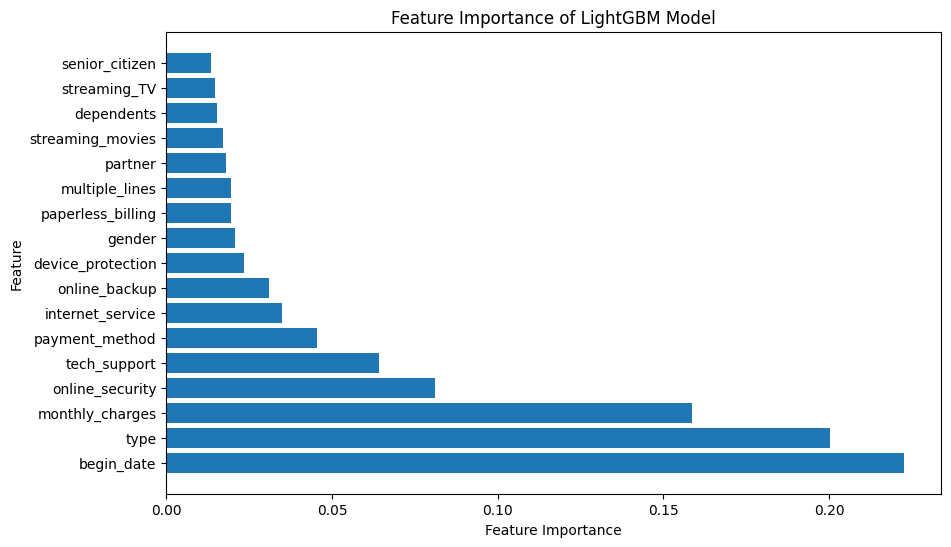

In [ ]:
feature_importances = model.feature_importances_
feature_names = label_X_train_val.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of LightGBM Model')
plt.show()

The top 3 important features are `monthly_charges`, `begin_date` and `payment_method`.

As I descibed before, there is significant different on `monthly_charges` of churned and stay customers, as well as the `payment_method`.

Based on the summary of this project, I have some suggestions to the company.

### Suggestion:

1. Encourage customers to sign the one year or two years contracts.
2. Give more promotional resources to automatic payment methods.
3. Pay more attention on customers who are in monthly contract but spend higher cost. If they have sign to leave, some retention solutions should be applied.
